# Browse TD-MPC2 Runs

Interactive notebook for monitoring training progress, analyzing runs, and managing videos.

## Setup

In [1]:
from pathlib import Path
import sys

# Ensure repo root is importable
ROOT = Path('..').resolve()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

# Configuration
LOGS_DIR = ROOT / 'logs'  # ROOT is already tdmpc2/
WANDB_PROJECT = 'wm-planning/mmbench'
WANDB_LIMIT = None  # No limit
CACHE_PATH = ROOT / 'discover' / 'runs_cache.parquet'
TARGET_STEP = 5_000_000

print(f"ROOT: {ROOT}")
print(f"LOGS_DIR: {LOGS_DIR}")
print(f"WANDB_PROJECT: {WANDB_PROJECT}")

ROOT: /home/projects/dharel/nadavt/repos/newt/tdmpc2
LOGS_DIR: /home/projects/dharel/nadavt/repos/newt/tdmpc2/logs
WANDB_PROJECT: wm-planning/mmbench


## Load Runs Data

In [2]:
from discover.cache import RunsCache

cache = RunsCache(
    logs_dir=LOGS_DIR,
    cache_path=CACHE_PATH,
    wandb_project=WANDB_PROJECT,
    wandb_limit=WANDB_LIMIT,
)

# Load data (set refresh=True to force re-fetch from local/wandb)
df_all, latest_ts, used_cache = cache.load(refresh=False)

print(f"Total rows: {len(df_all)}")
print(f"Using cache: {used_cache}")
print(f"Latest timestamp: {latest_ts}")
df_all.head()

Total rows: 3235
Using cache: True
Latest timestamp: 2025-12-19 04:56:30.553296


,task,local_run_id,exp_name,status,ckpt_step,steps,updated_at,wandb_run_id,run_dir,ckpt_path,found_in,url,summary
0,ms-pick-can,20251216_004843_expert_ms-pick-can,expert_ms-pick-can,running,0.0,5000000.0,2025-12-16T02:48:43.871188,None,/home/projects/dharel/nadavt/repos/newt/tdmpc2...,None,local,nan,None
1,og-ant-maze,20251216_004844_expert_og-ant-maze,expert_og-ant-maze,running,0.0,5000000.0,2025-12-16T02:48:44.222972,None,/home/projects/dharel/nadavt/repos/newt/tdmpc2...,None,local,nan,None
2,ms-pick-hammer,20251216_004845_expert_ms-pick-hammer,expert_ms-pick-hammer,running,0.0,5000000.0,2025-12-16T02:48:45.409009,None,/home/projects/dharel/nadavt/repos/newt/tdmpc2...,None,local,nan,None
3,atari-jamesbond,20251216_004858_expert_atari-jamesbond,expert_atari-jamesbond,running,0.0,5000000.0,2025-12-16T02:48:58.980682,None,/home/projects/dharel/nadavt/repos/newt/tdmpc2...,None,local,nan,None
4,atari-ms-pacman,20251216_004858_expert_atari-ms-pacman,expert_atari-ms-pacman,running,0.0,5000000.0,2025-12-16T02:48:58.648084,None,/home/projects/dharel/nadavt/repos/newt/tdmpc2...,None,local,nan,None


## Training Progress Overview

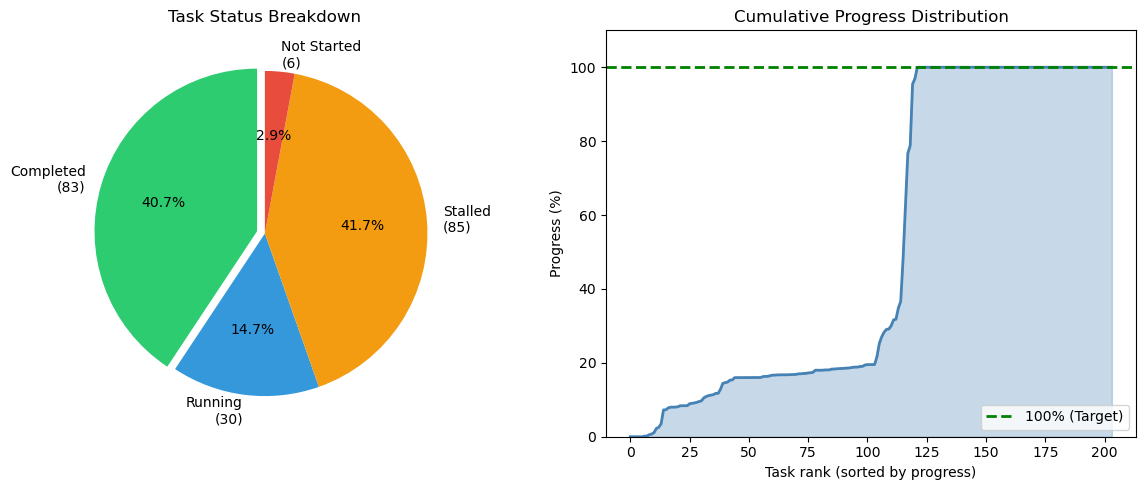

                 TRAINING PROGRESS SUMMARY                  
  Total tasks:            204
  Target step:         5,000,000
------------------------------------------------------------
  🟢 ✅ Completed:          83 (40.7%)
  🔵 🏃 Running:            30 (14.7%)  <- active in wandb
  🟠 ⏸️  Stalled:            85 (41.7%)  <- needs restart
  🔴 ❌ Not Started:         6 (2.9%)
------------------------------------------------------------
  Average progress:      51.2%
  Median progress:       19.5%
  Min steps:                0
  Max steps:           5,000,000


In [3]:
from discover.plots import training_overview

training_overview(df_all, target_step=TARGET_STEP)

## Currently Running Runs

Shows which tasks have active runs, which need to be restarted, and detects duplicate runs.


In [4]:
from discover.plots import running_runs_summary, tasks_needing_restart, duplicate_running_runs, currently_running_tasks

# Overall summary of running runs
running_summary = running_runs_summary(df_all, target_step=TARGET_STEP)

                         RUNNING RUNS SUMMARY                         
  Running runs (wandb):          60  ✓ confirmed by wandb
  Stale local 'running':        788  ⚠️  (local-only, likely crashed)
  Tasks with running runs:       48
  Tasks needing restart:         91  ⚠️  (incomplete, no active run)
  Tasks with duplicate runs:     12  🔄 (>1 run for same task)


In [5]:
# Tasks that are incomplete but have no running runs - these need to be restarted
needs_restart_df = tasks_needing_restart(df_all, target_step=TARGET_STEP)

                         RUNNING RUNS SUMMARY                         
  Running runs (wandb):          60  ✓ confirmed by wandb
  Stale local 'running':        788  ⚠️  (local-only, likely crashed)
  Tasks with running runs:       48
  Tasks needing restart:         91  ⚠️  (incomplete, no active run)
  Tasks with duplicate runs:     12  🔄 (>1 run for same task)

⚠️  TASKS NEEDING RESTART (91 tasks, no active runs in wandb):
----------------------------------------------------------------------
Task                                         Progress        Max Step
----------------------------------------------------------------------
   atari-yars-revenge                          97.0%       4,848,000
   atari-upndown                               95.4%       4,772,000
   pygame-landing                              78.8%       3,941,200
   mw-push-back                                48.2%       2,409,600
   og-point-arena                              36.6%       1,831,400
   pygame-hig

In [6]:
# Detect duplicate runs (multiple runs for the same task)
duplicates_df = duplicate_running_runs(df_all)



🔄 DUPLICATE RUNNING RUNS (12 tasks with >1 run):
----------------------------------------------------------------------
Task                                         Runs
----------------------------------------------------------------------
   ms-ant-run                                   2
   ms-cartpole-balance-sparse                   2
   ms-cartpole-swingup                          2
   ms-hopper-stand                              2
   ms-pick-banana                               2
   ms-pick-can                                  2
   ms-pick-cube-xarm6                           2
   ms-pick-fork                                 2
   ms-pick-hammer                               2
   ms-pick-mug                                  2
   ms-pick-tennis-ball                          2
   ms-reach-eepose                              2
----------------------------------------------------------------------
   Total duplicate runs: 12


In [7]:
# Get detailed info about duplicate runs with termination recommendations
from discover.plots import duplicate_run_details
dup_details_df = duplicate_run_details(df_all)



                            DUPLICATE RUNS - DETAILED ANALYSIS                            
  Tasks with duplicates: 12
  Total runs to review:  24
  Runs to terminate:     12

📋 ms-ant-run:
------------------------------------------------------------------------------------------
   wandb_run_id    exp_name                               step       action
------------------------------------------------------------------------------------------
   3pudn4cm        1                                   704,000       KEEP ✓
   vvq1ttvq        1                                   703,000       KILL ✗

📋 ms-cartpole-balance-sparse:
------------------------------------------------------------------------------------------
   wandb_run_id    exp_name                               step       action
------------------------------------------------------------------------------------------
   klpdf0o4        1                                   864,000       KEEP ✓
   mbkl2irj        1              

In [8]:
# Show all currently running tasks with their progress
running_tasks_df = currently_running_tasks(df_all, target_step=TARGET_STEP)


                         RUNNING RUNS SUMMARY                         
  Running runs (wandb):          60  ✓ confirmed by wandb
  Stale local 'running':        788  ⚠️  (local-only, likely crashed)
  Tasks with running runs:       48
  Tasks needing restart:         91  ⚠️  (incomplete, no active run)
  Tasks with duplicate runs:     12  🔄 (>1 run for same task)

🏃 CURRENTLY RUNNING TASKS (48 tasks, 60 runs per wandb):
   Note: wandb 'running' may include LSF-suspended jobs (SSUSP)
----------------------------------------------------------------------
Task                                       Runs     Progress     Max Step
----------------------------------------------------------------------
   ms-stack-cube                              1        7.2%      362,450
   ms-pick-cube-xarm6                         2        7.3%      364,650 🔄
   ms-pick-mug                                2        7.8%      390,300 🔄
   ms-pick-apple                              1        8.4%      420,300


## Per-Task Progress

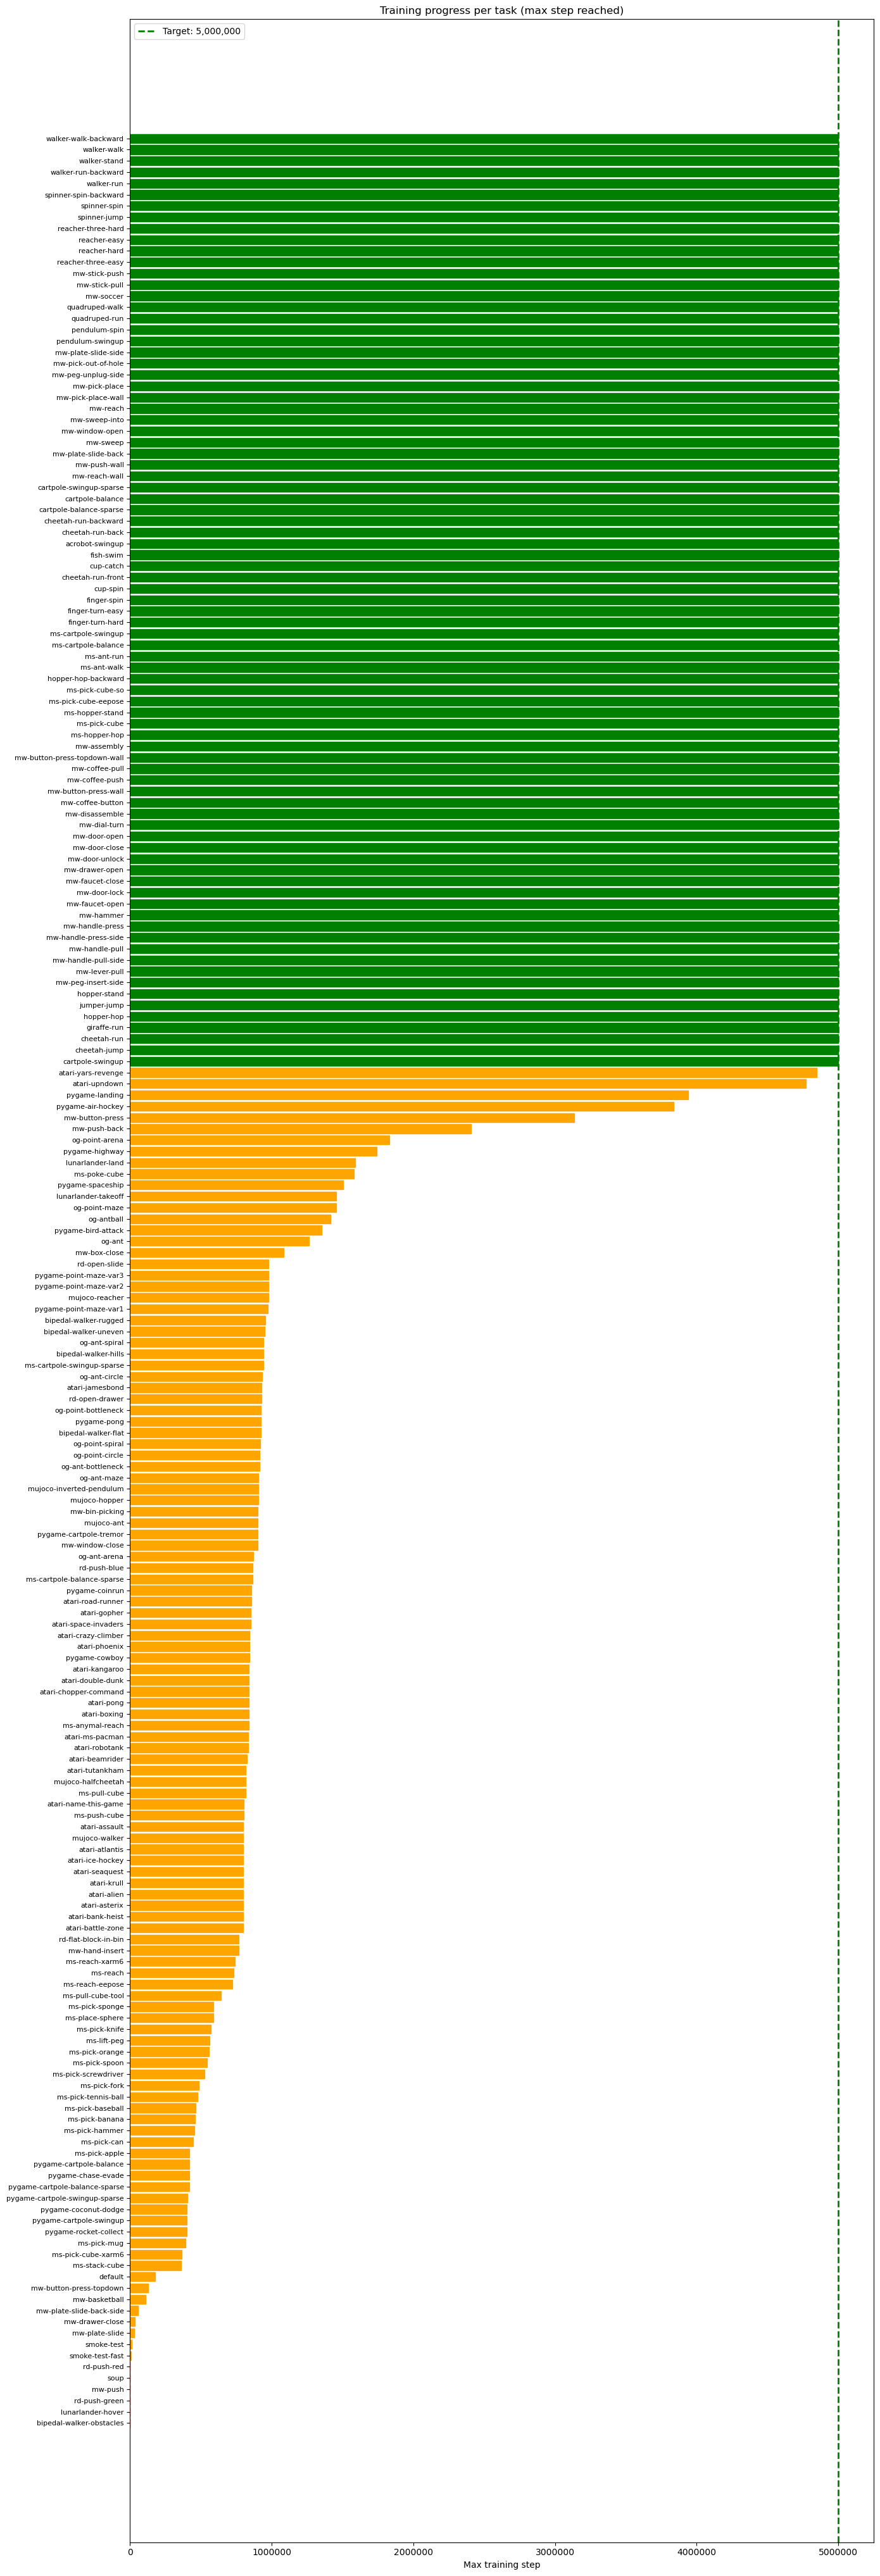

In [9]:
from discover.plots import plot_max_steps

# Green = completed, Orange = in progress, Red = not started
plot_max_steps(df_all, target_step=TARGET_STEP)

## Tasks Requiring Attention

In [10]:
from discover.plots import tasks_needing_attention

tasks_needing_attention(df_all, target_step=TARGET_STEP, bottom_n=15)

                      TASKS REQUIRING ATTENTION                       

❌ NOT STARTED (6 tasks):
----------------------------------------------------------------------
   • bipedal-walker-obstacles
   • lunarlander-hover
   • mw-push
   • rd-push-green
   • rd-push-red
   • soup

🐢 LAGGING TASKS (bottom 15 by progress):
----------------------------------------------------------------------
   • smoke-test-fast                                      8,000 (0.2%)
   • smoke-test                                          10,000 (0.2%)
   • mw-plate-slide                                      27,600 (0.6%)
   • mw-drawer-close                                     36,400 (0.7%)
   • mw-plate-slide-back-side                            55,400 (1.1%)
   • mw-basketball                                      111,800 (2.2%)
   • mw-button-press-topdown                            128,000 (2.6%)
   • default                                            175,000 (3.5%)
   • ms-stack-cube                     

## Progress by Domain

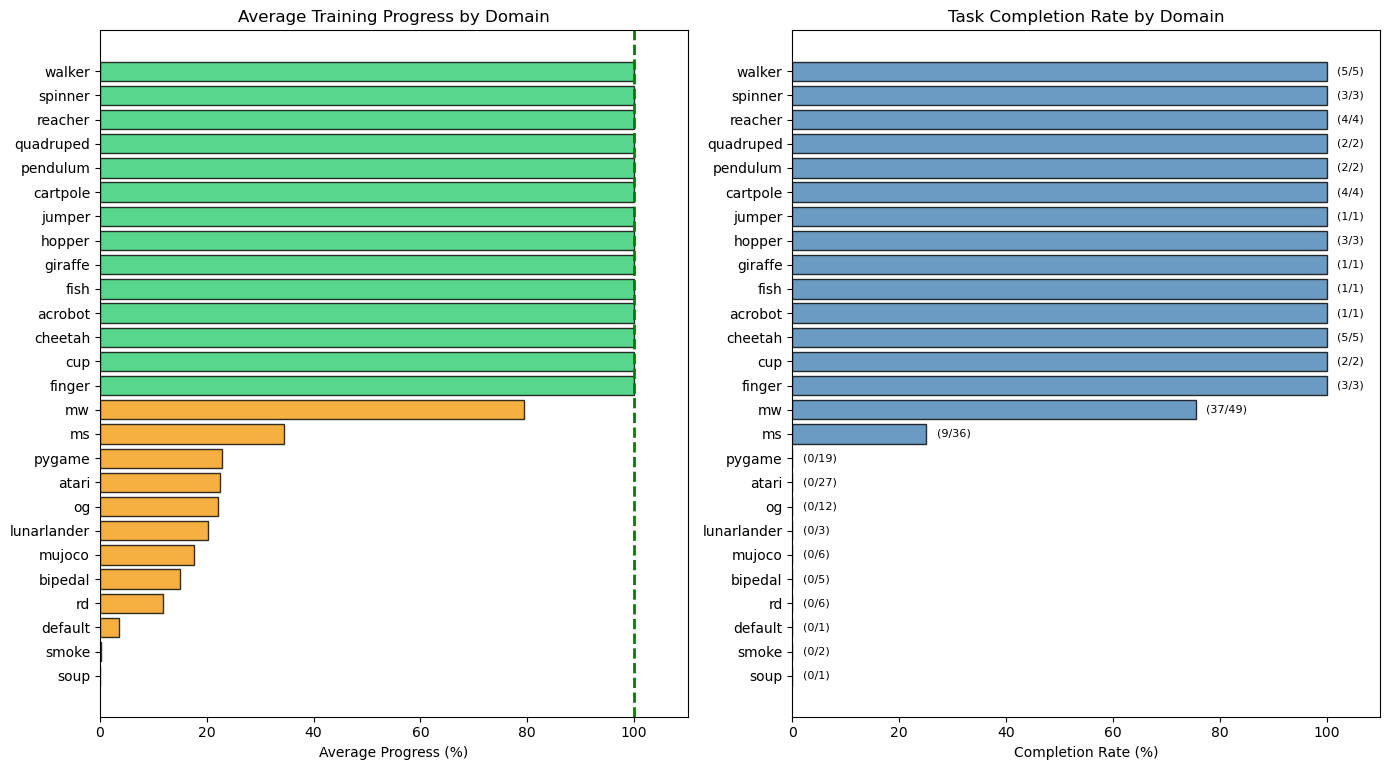


Domain Summary:
--------------------------------------------------------------------------------
Domain                  Tasks   Complete   Avg Progress   Completion %
--------------------------------------------------------------------------------
reacher                     4          4         100.0%         100.0%
quadruped                   2          2         100.0%         100.0%
hopper                      3          3         100.0%         100.0%
jumper                      1          1         100.0%         100.0%
giraffe                     1          1         100.0%         100.0%
fish                        1          1         100.0%         100.0%
cheetah                     5          5         100.0%         100.0%
acrobot                     1          1         100.0%         100.0%
finger                      3          3         100.0%         100.0%
cup                         2          2         100.0%         100.0%
spinner                     3          3

In [11]:
from discover.plots import progress_by_domain

progress_by_domain(df_all, target_step=TARGET_STEP)

## Tasks Ready for Evaluation (50%+ trained)

(with `min_progress = 0.5`)

In [12]:
min_progress = 0.5

In [16]:
from discover.eval import tasks_ready_for_eval

ready_df, tasks_need_eval, tasks_with_videos = tasks_ready_for_eval(
    df_all,
    logs_dir=LOGS_DIR,
    target_step=TARGET_STEP,
    min_progress=min_progress
)

print(f"\nTasks needing eval: {len(tasks_need_eval)}")
print(f"Tasks with videos: {len(tasks_with_videos)}")

                   TASKS READY FOR EVALUATION (≥50% trained)                    

Total tasks at ≥50%: 88
  ✅ With videos:    87
  ❌ Without videos: 1

────────────────────────────────────────────────────────────────────────────────
Tasks WITH videos:
────────────────────────────────────────────────────────────────────────────────
  ✅ acrobot-swingup                                5,000,000 (100.0%)
  ✅ cartpole-balance                               5,000,000 (100.0%)
  ✅ cartpole-swingup                               5,000,000 (100.0%)
  ✅ cartpole-balance-sparse                        5,000,000 (100.0%)
  ✅ cartpole-swingup-sparse                        5,000,000 (100.0%)
  ✅ cheetah-jump                                   5,000,000 (100.0%)
  ✅ cheetah-run-back                               5,000,000 (100.0%)
  ✅ cheetah-run                                    5,000,000 (100.0%)
  ✅ finger-turn-hard                               5,000,000 (100.0%)
  ✅ fish-swim                        

## Generate Eval Script (for tasks without videos)

In [17]:
from discover.eval import generate_eval_script

if tasks_need_eval:
    generate_eval_script(
        tasks=tasks_need_eval,
        output_dir=ROOT / 'jobs',
        project_root=ROOT,
    )
else:
    print(f"✅ All {min_progress*100}%+ trained tasks already have videos!")

✅ Written task list to: /home/projects/dharel/nadavt/repos/newt/tdmpc2/jobs/tasks_need_eval.txt
   (1 tasks)
✅ Written LSF script to: /home/projects/dharel/nadavt/repos/newt/tdmpc2/jobs/run_eval_need_videos.lsf

📋 To submit the eval jobs:
   make submit-eval


## Collect Videos for Download

In [18]:
from discover.eval import collect_videos

videos_df = collect_videos(
    df_all,
    logs_dir=LOGS_DIR,
    output_dir=ROOT / 'discover' / 'videos_for_presentation',
    target_step=TARGET_STEP,
    min_progress=min_progress,
    create_symlinks=True,
)

                       VIDEOS COLLECTED FOR PRESENTATION                        

📁 Output directory: /home/projects/dharel/nadavt/repos/newt/tdmpc2/discover/videos_for_presentation
   Total videos: 87
   Method: symlinks

────────────────────────────────────────────────────────────────────────────────
Task                                                  Step   Progress
────────────────────────────────────────────────────────────────────────────────
  acrobot-swingup                                5,000,000     100.0%
  atari-upndown                                  4,772,000      95.4%
  atari-yars-revenge                             4,848,000      97.0%
  cartpole-balance                               5,000,000     100.0%
  cartpole-balance-sparse                        5,000,000     100.0%
  cartpole-swingup                               5,000,000     100.0%
  cartpole-swingup-sparse                        5,000,000     100.0%
  cheetah-jump                                   5,000,